# 多GPU训练



In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

简单网络

In [2]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss(reduction='none')

向多个设备分发参数

In [4]:
# 把每个层的参数params挪到对应的gpu上
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params = get_params(params, d2l.try_gpu(0))
print("所有层的权重：",new_params)
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

所有层的权重： [tensor([[[[-6.2382e-03,  8.4831e-03, -4.2438e-03],
          [ 7.7261e-03, -6.0294e-03,  7.4311e-03],
          [ 3.6747e-03,  1.0501e-03,  2.4639e-03]]],


        [[[-6.2980e-03,  1.2408e-02,  4.0762e-03],
          [ 7.0419e-03,  5.6217e-03, -1.8463e-02],
          [-9.6572e-03,  2.9374e-03,  1.0602e-03]]],


        [[[ 1.8262e-02, -7.9952e-04,  2.9491e-04],
          [-5.2758e-03,  1.0866e-02, -4.1515e-03],
          [-9.0630e-03,  4.7479e-04,  7.5221e-03]]],


        [[[-6.4754e-03, -1.2742e-02,  7.8240e-03],
          [ 6.2819e-03, -2.9086e-03, -1.7677e-02],
          [-1.7976e-02,  1.2795e-02,  5.4223e-03]]],


        [[[ 5.5044e-03, -3.5437e-03, -1.2420e-02],
          [-5.6875e-03, -8.2623e-04,  2.0555e-02],
          [-2.0157e-02,  1.1306e-02,  7.7667e-03]]],


        [[[-9.4679e-03,  6.7965e-04,  8.4635e-04],
          [-3.0255e-04,  5.5167e-03,  1.4900e-02],
          [ 3.5803e-03,  1.2966e-03, -6.0024e-03]]],


        [[[-1.3316e-03,  1.3160e-02,  1.0241e-02]

`allreduce`函数将所有向量相加，并将结果广播给所有GPU

In [11]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)
#将每个张量中的元素的值,乘上(i+1)
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')


将一个小批量数据均匀地分布在多个GPU上

In [5]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))


In [5]:
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

在一个小批量上实现多GPU训练

In [6]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    ls = [loss(lenet(
        X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:
        l.backward()
    with torch.no_grad():
        # print("param[0]:",device_params[0])
        for i in range(len(device_params[0])):
            # allreduce`函数将所有向量相加，并将结果广播给所有的GPU，实现参数共享
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
            #c:gpu数量 i:层数
            # 每个gpu上都有模型的完整参数，device_params为list类型，2个gpu，每个gpu里面都有8层参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0])

定义训练函数

In [9]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [get_params(params, d) for d in devices]
    print("devices_params:",len(device_params))
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

在单个GPU上运行

测试精度：0.80，3.0秒/轮，在[device(type='cuda', index=0)]


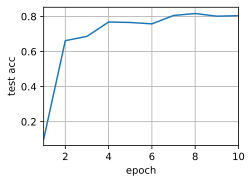

In [13]:
train(num_gpus=1, batch_size=256, lr=0.2)

增加为2个GPU

devices_params: [[tensor([[[[ 1.4095e-02,  1.0661e-03, -4.7361e-03],
          [ 8.6813e-03, -1.0129e-02,  2.4016e-03],
          [-1.8262e-02,  3.9353e-03, -8.8699e-03]]],


        [[[ 8.6554e-03, -1.9946e-02,  1.6620e-03],
          [ 4.8552e-03, -4.6950e-03, -1.4565e-02],
          [-1.1621e-02,  1.8404e-02, -3.6394e-03]]],


        [[[-9.8328e-03, -6.4838e-04, -1.2651e-02],
          [ 6.6070e-03, -4.8762e-03,  1.6837e-02],
          [-3.0309e-03,  1.2632e-03,  8.8394e-03]]],


        [[[ 9.6058e-03,  4.3893e-03, -2.3373e-02],
          [-6.0313e-04, -5.2469e-03, -1.8722e-03],
          [-7.6630e-03,  2.8686e-03, -5.1216e-03]]],


        [[[ 3.4858e-03,  5.0553e-03,  9.1021e-03],
          [-1.4257e-02,  1.4853e-02,  3.0907e-03],
          [ 1.6305e-02,  3.5642e-03,  1.0498e-02]]],


        [[[-1.5420e-02, -8.5878e-03,  3.5091e-03],
          [ 8.2135e-04, -3.4448e-03, -6.2000e-03],
          [ 4.5958e-03,  1.6347e-03, -4.5230e-03]]],


        [[[ 9.4057e-04, -1.0130e-02,  1.

KeyboardInterrupt: 

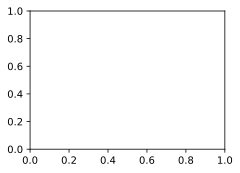

In [10]:
train(num_gpus=2, batch_size=256, lr=0.2)